<a href="https://colab.research.google.com/github/iamarawin/skin-cancer-classification/blob/main/SkinCancer_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Skin Cancer classification (Smart Healthcare System)**
By Arawinkumaar Selvakkumar


---






# **Part 1: Creating the CNN and training it with the skin cancer dataset**

In [ ]:
# Connect to Google Drive to import the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Add my working directory to the Notebook path
import sys
WORKSPACE = "/content/drive/MyDrive/IFN712/" # Path to the workspace
sys.path.append(WORKSPACE)

In [ ]:
#!unzip /content/drive/MyDrive/IFN712/dataset.zip


In [ ]:
#Importing Libraries
import os #python - 3.8.5

import cv2 #Importing openCV-2  : cv2 - 4.0.1
        
#Basic Python Libraries 
import numpy as np # numpy - 1.18.5
import pandas as pd #pandas - 1.1.1

#Visualization Libraries 
import seaborn as sns # Version - seaborn - 0.11.0
import matplotlib.pyplot as plt  # Version - matplotlib - 3.3.1

#sklearn 
import sklearn.metrics as metrics # Version - sklearn - 0.23.2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

#Keras
from keras.utils import np_utils # Version - keras - 2.4.3

#TensorFlow
from tensorflow.keras.models import Model # Version -tensorflow - 2.3.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import  VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
# Obtain list of image paths. Last line is to verify number of image paths obtained matches number of expected images for our dataset.
# *hard coded* arguments and values
args = {
	"model": "simple_nn.model",
	"label_bin": "simple_nn_lb.pickle",
	"plot": "simple_nn_lb.jpeg"
}

filePaths = []
#Fetching filenames from the data directory
for directory, _, ImageFilenames in os.walk(WORKSPACE):
    for ImageName in ImageFilenames:
        if (ImageName[-3:] == 'jpg'):
            filePaths.append(os.path.join(directory, ImageName))

#Check whether all the images are imported from the dataset 
if len(filePaths) == 1000:
    print("All Files are imported")
else:
    print("Error ! Some Files are missing !!!")
print(len(filePaths))

All Files are imported
1000


/content/drive/MyDrive/IFN712/dataset/benign/430.jpg
(224, 224, 3)


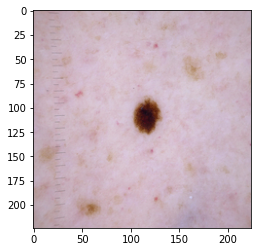

/content/drive/MyDrive/IFN712/dataset/malignant/403.jpg
(224, 224, 3)


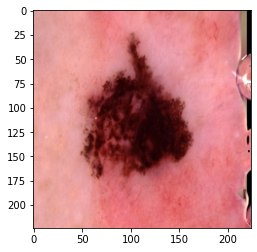

In [ ]:
# View a sample image in the dataSet
def SampleImage (fileName):
    print(filePaths[fileName])
    imageSample = cv2.imread(filePaths[fileName])
    Img2=imageSample[:,:,::-1]
    print(imageSample.shape)
    plt.imshow(Img2)
    plt.show()

SampleImage(250) #Benign
SampleImage(750) # Malignant

In [ ]:
# Creating an array containing image label and data from the above created list

ImageData = [] ; ImageLabel = []
IMG_SIZE = 224 #Image Size

print("Code block Running ..")
for file_path in filePaths:
    label = file_path.split(os.path.sep)[-2]
    
#     image = cv2.imread(file_path)
    image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    #Resizing the image to 224 x 224 resolution and the normalizing the image pixel to by dividing 255  
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))/255.0 
    
    ImageData.append(image) #Store resized and Normalised Image into a list 
    ImageLabel.append(label)

X = np.array(ImageData)
y = np.array(ImageLabel)
print("Code block completed ..")

print("Shape of the entire image array -",X.shape)
print("Size of Label array - ", y.shape)

Code block Running ..
Code block completed ..
Shape of the entire image array - (1000, 224, 224, 3)
Size of Label array -  (1000,)


       Class  Labels
0     benign     500
1  malignant     500


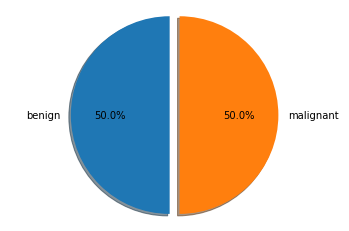

In [ ]:
#Summary of the two classes of images
yy =y.copy()

y_df = pd.DataFrame(y, columns=['Labels'])

ClassCount_df=y_df['Labels'].value_counts()

ClassCount_df_02=pd.DataFrame(ClassCount_df).reset_index()


ClassCount_df_02=ClassCount_df_02.rename(columns={"index": "Class"})

print(ClassCount_df_02)

# Pie chart distribution of the two classes in the dataset
labels = ClassCount_df_02['Class'] ; sizes = ClassCount_df_02['Labels']

explode = (0,0.1)  # Explode only 2nd SLice i.e. 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()


In [ ]:
# One-Hot encoding for all the two classes 

le = LabelEncoder()
y_encoded = le.fit_transform(y)

#Converting to one hot encoding 
y_encoded = np_utils.to_categorical(y_encoded)
print("Total Files converted - ", len(y_encoded))
# print(y_encoded, '\n')


Total Files converted -  1000


In [ ]:
#Splitting the data into Training and Testing using Stratified Sampling

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30,  random_state=43, stratify=y_encoded)

print("Number of Training Images and its Dimension  - ", X_train.shape) 


print("Number of Test Images and its Dimension - ", X_test.shape)

Number of Training Images and its Dimension  -  (700, 224, 224, 3)
Number of Test Images and its Dimension -  (300, 224, 224, 3)


In [ ]:
#Data augmentation : To increase the number of images, augmenting the present images to expand the dataset. 

train_aug = ImageDataGenerator(rotation_range=15)

#The pictures of the moles are all in the correct angle. By rotating the image, we can train the CNN to classify images of skin cancer although they have been tilted. 
#https://keras.io/api/preprocessing/image/

In [ ]:
#Transfer learning with VGG19 

def Model_PreTrained():
    
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3)) 

    base_model.trainable = False # Freeze the Base model
    
    #Include_Top - We have not included the fully connected layer at the top 
    #Weights = We have Used pretrained weights from the famous Imagenet Model here 
    #Input Shape - Shape of the image was kept same as mentioned in the previous steps
    #pooling - We have not included any pooling here - So that no global average pooling will be applied to last convolutional block
    
   
    output = base_model.layers[-1].output #Last layer will be our fully connected output layer
    
    output = Flatten()(output) #Since the output is batch, i.e. without feature axis, Flattening the output layer adds an extra channel dimension. Flattening is converting the data into a 1-dimensional array for inputting it to the next layer
    
    model = Model(base_model.input, outputs=output) #Model input and outputs 
    
    ## Freeze all the layers
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
# Neural Transfer 
skinCancer_model = Sequential()

skinCancer_model.add(Model_PreTrained()) #VGG19 model
skinCancer_model.add(Dropout(0.25))

#Adding the Dense Layers 
skinCancer_model.add(Dense(128, activation='relu'))
skinCancer_model.add(Dropout(0.25))
skinCancer_model.add(Dense(64, activation='relu'))

skinCancer_model.add(Dense(2, activation='softmax'))

skinCancer_model.summary() 


#There are 20M non trained parameters, which are from VGG19. Here in the transfer learning we have freezed the VGG19 model (base Model) i.e. layer1.trainable = False

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 25088)             20024384  
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 23,244,162
Trainable params: 3,219,778
Non-

In [ ]:
# Set constants and hyperparameter values:
LR = 0.0001  #Learning Rate (learning_rate)
EPOCHS = 15 #Number of iterations - 7 or 30
BATCH_SIZE = 32 # How many images are trained together - 32

#instantiate the optimizer (change to learning_rate/lr)
optim = Adam(learning_rate = LR, decay = LR/EPOCHS)

#Configure the model Losses and metrics
skinCancer_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

#Train the Model 
history = skinCancer_model.fit(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

Epoch 1/15
21/21 [==============================] - 70s 2s/step - loss: 0.6690 - accuracy: 0.5868 - val_loss: 0.5633 - val_accuracy: 0.7067
Epoch 2/15
21/21 [==============================] - 12s 573ms/step - loss: 0.5228 - accuracy: 0.7470 - val_loss: 0.4721 - val_accuracy: 0.8100
Epoch 3/15
21/21 [==============================] - 12s 576ms/step - loss: 0.4619 - accuracy: 0.7814 - val_loss: 0.3668 - val_accuracy: 0.8300
Epoch 4/15
21/21 [==============================] - 12s 568ms/step - loss: 0.4128 - accuracy: 0.8039 - val_loss: 0.3367 - val_accuracy: 0.8733
Epoch 5/15
21/21 [==============================] - 12s 568ms/step - loss: 0.3614 - accuracy: 0.8488 - val_loss: 0.3236 - val_accuracy: 0.8400
Epoch 6/15
21/21 [==============================] - 12s 571ms/step - loss: 0.3498 - accuracy: 0.8488 - val_loss: 0.3556 - val_accuracy: 0.8667
Epoch 7/15
21/21 [==============================] - 12s 569ms/step - loss: 0.3620 - accuracy: 0.8278 - val_loss: 0.2979 - val_accuracy: 0.8800
Ep

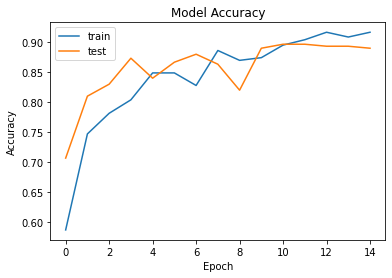

In [ ]:
#Model Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Graph Labelling 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

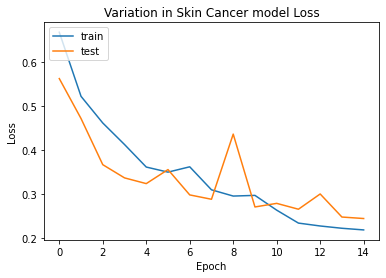

In [ ]:
#Model Loss variation with epoches 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Variation in Skin Cancer model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Testing the model 
TestResult = skinCancer_model.evaluate(X_test, y_test)
print("Model test accuracy : %f." %(TestResult[1]*100))

10/10 [==============================] - 7s 714ms/step - loss: 0.2440 - accuracy: 0.8900
Model test accuracy : 88.999999.


Predicting the labels for test data-set ... 
Extracting actual test data-set labels ... 
Confusion Matrix for the model
           Benign  Malignant
Benign        131         19
Malignant      14        136


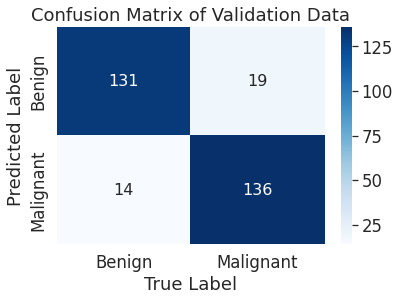

In [ ]:
# Confusion matrix to evaluate the model classification accuracy 

print("Predicting the labels for test data-set ... ")
y_pred = np.argmax(skinCancer_model.predict(X_test), axis=1) # Predicting results on test data set

print("Extracting actual test data-set labels ... ")
y_test_labels = np.argmax(y_test, axis=1) # Extracting actual test labels 

print("Confusion Matrix for the model")
EvaluationMatrix = confusion_matrix(y_test_labels, y_pred)
EvaluationMatrix_df = pd.DataFrame(EvaluationMatrix, index=le.classes_, columns=le.classes_)
EvaluationMatrix_df.columns =['Benign', 'Malignant']
EvaluationMatrix_df.index =['Benign', 'Malignant']

print(EvaluationMatrix_df.head())

#Creating the Heat Map
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(EvaluationMatrix_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='Blues')

plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

Classification report
              precision    recall  f1-score   support

      Benign       0.90      0.87      0.89       150
   Malignant       0.88      0.91      0.89       150

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



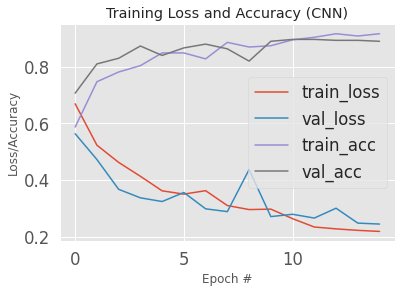

In [ ]:
# evaluate the network
print("Classification report")
predictions = skinCancer_model.predict(x=X_test, batch_size=BATCH_SIZE)
target_names = ['Benign', 'Malignant']
print(classification_report(y_test.argmax(axis=1), y_pred, target_names=target_names))

# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (CNN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.savefig(args["plot"])
plt.show()

In [ ]:
# Saving the built model skinCancer_model for deployment or future use .
# save the model and label binarizer to 

print("[INFO] serializing network and label binarizer...")
skinCancer_model.save(args["model"], save_format="h5")
f = open(args["label_bin"], "wb")
f.write(pickle.dumps(le))
f.close()

[INFO] serializing network and label binarizer...


# **Part 2: Implementing the FGSM attack to the CNN**

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MSE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [ ]:
def generate_image_adversary(model, image, label, eps=2 / 255.0):
	# cast the image
	image = tf.cast(image, tf.float32)

	# record our gradients
	with tf.GradientTape() as tape:
		# explicitly indicate that our image should be tacked for
		# gradient updates
		tape.watch(image)

		# use our model to make predictions on the input image and
		# then compute the loss
		pred = skinCancer_model(image)
		loss = MSE(label, pred)

	# calculate the gradients of loss with respect to the image, then
	# compute the sign of the gradient
	gradient = tape.gradient(loss, image)
	signedGrad = tf.sign(gradient)

	# construct the image adversary
	adversary = (image + (signedGrad * eps)).numpy()

	# return the image adversary to the calling function
	return adversary

In [ ]:
# make predictions on the testing set for the model trained on
# non-adversarial images
(loss, acc) = skinCancer_model.evaluate(x=X_test, y=y_test, verbose=0)
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

[INFO] loss: 0.2440, acc: 0.8900


In [ ]:
# loop over a sample of our testing images
ImagePredList = []
AdverserialPredList = []
for i in range(len(X_test)):#np.random.choice(np.arange(0, len(X_test)), size=(10,)):
	# grab the current image and label
	image = X_test[i]
	label = y_test[i]

	# generate an image adversary for the current image and make
	# a prediction on the adversary
	adversary = generate_image_adversary(skinCancer_model,
		image.reshape(1, 224, 224, 3), label, eps=0.1)
	pred = skinCancer_model.predict(adversary)

	# scale both the original image and adversary to the range
	# [0, 255] and convert them to an unsigned 8-bit integers
	adversary = adversary.reshape((224, 224, 3)) * 255
	adversary = np.clip(adversary, 0, 255).astype("uint8")
	image = image.reshape((224, 224, 3)) * 255
	image = image.astype("uint8")

	# resize the images so we can better visualize them
	image = cv2.resize(image,(224, 224))
	adversary = cv2.resize(adversary, (224, 224))

	# determine the predicted label for both the original image and
	# adversarial image
	imagePred = label.argmax()
	adversaryPred = pred[0].argmax()
	color = (0, 255, 0)
	
	# if the image prediction does not match the adversarial
	# prediction then update the color
	if imagePred != adversaryPred:
		color = (0, 0, 255)
	
	ImagePredList.append(imagePred)

	AdverserialPredList.append(adversaryPred)


0


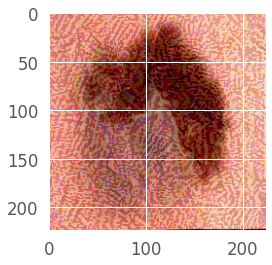

In [ ]:
print(adversaryPred)
plt.imshow(adversary)

1


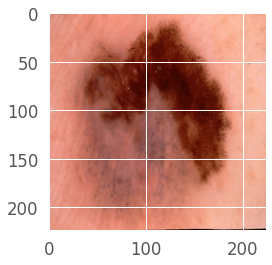

In [ ]:
print(imagePred)
plt.imshow(image)
plt.show()

In [ ]:
# Testing the model 
TestResult = skinCancer_model.evaluate(X_test, y_test)
print("Model test accuracy : %f." %(TestResult[1]*100))

10/10 [==============================] - 3s 262ms/step - loss: 0.2440 - accuracy: 0.8900
Model test accuracy : 88.999999.


Confusion Matrix for the model
           Benign  Malignant
Benign          2        148
Malignant     125         25


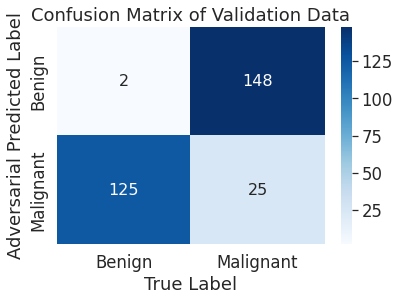

In [ ]:
# Confusion matrix to evaluate the model classification accuracy 

print("Confusion Matrix for the model")
EvaluationMatrix = confusion_matrix(ImagePredList, AdverserialPredList)
EvaluationMatrix_df = pd.DataFrame(EvaluationMatrix, index=le.classes_, columns=le.classes_)
EvaluationMatrix_df.columns =['Benign', 'Malignant']
EvaluationMatrix_df.index =['Benign', 'Malignant']

print(EvaluationMatrix_df.head())

#Creating the Heat Map
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(EvaluationMatrix_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='Blues')

plt.xlabel("True Label")
plt.ylabel("Adversarial Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()



---



---



---


-----------------